## Setup

In [3]:
!pip install kaggle
!pip install opendatasets
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install nltk
!pip install seaborn
!pip install scikit-learn

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


Defaulting to user installation because normal site-packages is not writeable


In [4]:
import opendatasets as od
 
od.download("https://www.kaggle.com/datasets/stackoverflow/stacksample/")


Skipping, found downloaded files in "./stacksample" (use force=True to force download)


In [ ]:
# Removing the Tags.csv file beacuse we don't need it
import os

os.remove("stacksample/Tags.csv")

## Data preprocessing

In [1]:
import pandas as pd
import os

class DataProcessor:
    def __init__(self, answers_file, questions_file, processed_file_path, data_analysis_path):
        self.answers_file = answers_file
        self.questions_file = questions_file
        self.processed_file_path = processed_file_path
        self.data_analysis_path = data_analysis_path

    def load_data(self):
        self.questions_df = pd.read_csv(self.questions_file, encoding="ISO-8859-1")
        self.answers_df = pd.read_csv(self.answers_file, encoding="ISO-8859-1")

    def process_data(self):
        total_answers_score = self.answers_df.groupby('ParentId')['Score'].sum().reset_index()
        total_answers_score.rename(columns={'Score': 'TotalAnswersScore', 'ParentId': 'Id'}, inplace=True)

        self.merged_df = self.questions_df.merge(total_answers_score, on='Id', how='left')
        self.merged_df['TotalAnswersScore'] = self.merged_df['TotalAnswersScore'].fillna(0)
        self.merged_df['Closed'] = self.merged_df['ClosedDate'].notnull()

        columns_to_remove = ['OwnerUserId', 'CreationDate', 'ClosedDate']
        self.merged_df.drop(columns=columns_to_remove, inplace=True)

    def save_processed_data(self):
        self.merged_df.to_csv(self.processed_file_path, index=False)


In [2]:
answers_file = 'stacksample/Answers.csv'
questions_file = 'stacksample/Questions.csv'
processed_file_path = './Questions_with_TotalAnswersScore.csv'
data_analysis_path = './data_analysis/'

processor = DataProcessor(answers_file, questions_file, processed_file_path, data_analysis_path)
processor.load_data()
processor.process_data()
processor.save_processed_data()

del processor

### To speed up development, you can use smaller set for faster results and testing phase

In [3]:
import pandas as pd

answers_df = pd.read_csv('./Questions_with_TotalAnswersScore.csv', encoding="ISO-8859-1")

first_10000_rows = answers_df.head(10000)

first_10000_rows.to_csv('./First_10000_Questions_with_TotalAnswersScore.csv', index=False)

 = './First_10000_Questions_with_TotalAnswersScore.csv';

# Data analysis

In [52]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import re
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

class DataAnalysis:
    def __init__(self, processed_file_path, data_analysis_path):
        self.processed_file_path = processed_file_path
        self.data_analysis_path = data_analysis_path
        self.load_data()
        self.stop_words = set(stopwords.words('english'))
        self.lemmatizer = WordNetLemmatizer()

    def load_data(self):
        if not os.path.exists(self.data_analysis_path):
            os.makedirs(self.data_analysis_path)
        self.modified_questions_df = pd.read_csv(self.processed_file_path, encoding="ISO-8859-1") 
                         
    def calculate_lengths(self):
        self.modified_questions_df['TitleLength'] = self.modified_questions_df['Title'].apply(lambda x: len(x))
        self.modified_questions_df['BodyLength'] = self.modified_questions_df['Body'].apply(lambda x: len(x))

    def calculate_word_counts(self):
        self.modified_questions_df['NumberOfTitleWords'] = self.modified_questions_df['Title'].apply(lambda x: len(x.split()))
        self.modified_questions_df['NumberOfBodyWords'] = self.modified_questions_df['Body'].apply(lambda x: len(x.split()))
        self.modified_questions_df['NumberOfTitleStopWords'] = self.modified_questions_df['Title'].apply(lambda x: len([word for word in x.lower().split() if word in self.stop_words]))
        self.modified_questions_df['NumberOfBodyStopWords'] = self.modified_questions_df['Body'].apply(lambda x: len([word for word in x.lower().split() if word in self.stop_words]))

    def calculate_characteristics(self):
        special_chars = re.compile('[^a-z0-9]', re.IGNORECASE)
        self.modified_questions_df['NumberOfTitleSpecialCharacters'] = self.modified_questions_df['Title'].apply(lambda x: len(special_chars.findall(x)))
        self.modified_questions_df['NumberOfBodySpecialCharacters'] = self.modified_questions_df['Body'].apply(lambda x: len(special_chars.findall(x)))
        self.modified_questions_df['NumberOfTitleNumericalCharacters'] = self.modified_questions_df['Title'].apply(lambda x: sum(c.isdigit() for c in x))
        self.modified_questions_df['NumberOfBodyNumericalCharacters'] = self.modified_questions_df['Body'].apply(lambda x: sum(c.isdigit() for c in x))
        self.modified_questions_df['NumberOfTitleUpperCaseCharacters'] = self.modified_questions_df['Title'].apply(lambda x: sum(c.isupper() for c in x))
        self.modified_questions_df['NumberOfBodyUpperCaseCharacters'] = self.modified_questions_df['Body'].apply(lambda x: sum(c.isupper() for c in x))

    def calculate_tfidf(self):
        tfidf_vectorizer = TfidfVectorizer(max_features=100, tokenizer=self.tokenize)
        self.modified_questions_df['TitleTfidf'] = list(tfidf_vectorizer.fit_transform(self.modified_questions_df['Title']).toarray())
        self.modified_questions_df['BodyTfidf'] = list(tfidf_vectorizer.fit_transform(self.modified_questions_df['Body']).toarray())

    def tokenize(self, text):
        return [self.lemmatizer.lemmatize(token) for token in re.findall(r'\b\w+\b', text.lower()) if token not in self.stop_words]

    def plot_distributions(self):
        plt.figure(figsize=(16, 6))

        plt.subplot(1, 2, 1)
        plt.hist(self.modified_questions_df['TitleLength'], bins=200)
        plt.xlabel('Title Length (Number of Characters)')
        plt.ylabel('Number of Questions')

        plt.subplot(1, 2, 2)
        plt.hist(self.modified_questions_df['BodyLength'], bins=200)
        plt.xlabel('Body Length (Number of Characters)')
        plt.ylabel('Number of Questions')

        plt.tight_layout()

        plt.savefig(data_analysis_path + 'title_body_length_distribution.png', dpi=300)
        plt.show()

        plt.figure(figsize=(16, 12))

        plt.subplot(2, 2, 1)
        plt.hist(self.modified_questions_df['NumberOfTitleWords'], bins=200)
        plt.xlabel('Number of Words in Title')
        plt.ylabel('Number of Questions')

        plt.subplot(2, 2, 2)
        plt.hist(self.modified_questions_df['NumberOfBodyWords'], bins=200)
        plt.xlabel('Number of Words in Body')
        plt.ylabel('Number of Questions')

        plt.subplot(2, 2, 3)
        plt.hist(self.modified_questions_df['NumberOfTitleStopWords'], bins=200)
        plt.xlabel('Number of Stop Words in Title')
        plt.ylabel('Number of Questions')

        plt.subplot(2, 2, 4)
        plt.hist(self.modified_questions_df['NumberOfBodyStopWords'], bins=200)
        plt.xlabel('Number of Stop Words in Body')
        plt.ylabel('Number of Questions')

        plt.tight_layout()
        plt.savefig(data_analysis_path + 'title_body_words_distribution.png', dpi=300)
        plt.show()
        
        plt.figure(figsize=(16, 18))

        plt.subplot(3, 2, 1)
        plt.hist(self.modified_questions_df['NumberOfTitleSpecialCharacters'], bins=200)
        plt.xlabel('Number of Special Characters in Title')
        plt.ylabel('Number of Questions')

        plt.subplot(3, 2, 2)
        plt.hist(self.modified_questions_df['NumberOfBodySpecialCharacters'], bins=200)
        plt.xlabel('Number of Special Characters in Body')
        plt.ylabel('Number of Questions')

        plt.subplot(3, 2, 3)
        plt.hist(self.modified_questions_df['NumberOfTitleNumericalCharacters'], bins=200)
        plt.xlabel('Number of Numerical Characters in Title')
        plt.ylabel('Number of Questions')

        plt.subplot(3, 2, 4)
        plt.hist(self.modified_questions_df['NumberOfBodyNumericalCharacters'], bins=200)
        plt.xlabel('Number of Numerical Characters in Body')
        plt.ylabel('Number of Questions')

        plt.subplot(3, 2, 5)
        plt.hist(self.modified_questions_df['NumberOfTitleUpperCaseCharacters'], bins=200)
        plt.xlabel('Number of Uppercase Characters in Title')
        plt.ylabel('Number of Questions')

        plt.subplot(3, 2, 6)
        plt.hist(self.modified_questions_df['NumberOfBodyUpperCaseCharacters'], bins=200)
        plt.xlabel('Number of Uppercase Characters in Body')
        plt.ylabel('Number of Questions')

        plt.tight_layout()
        plt.savefig(data_analysis_path + 'title_body_special_numerical_uppercase_characters_distribution.png', dpi=300)
        plt.show()
        
    def plot_correlation_matrix(self):
        correlation_matrix = self.modified_questions_df.corr(numeric_only=True)
        plt.figure(figsize=(12, 12))
        sns.heatmap(data=correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
        plt.tight_layout()

    def save_analyzed_data(self, text):
        self.modified_questions_df.to_csv(text, index=False)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/marcin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/marcin/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/marcin/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


/Users/marcin/Library/Python/3.9/lib/python/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/marcin/Library/Python/3.9/lib/python/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


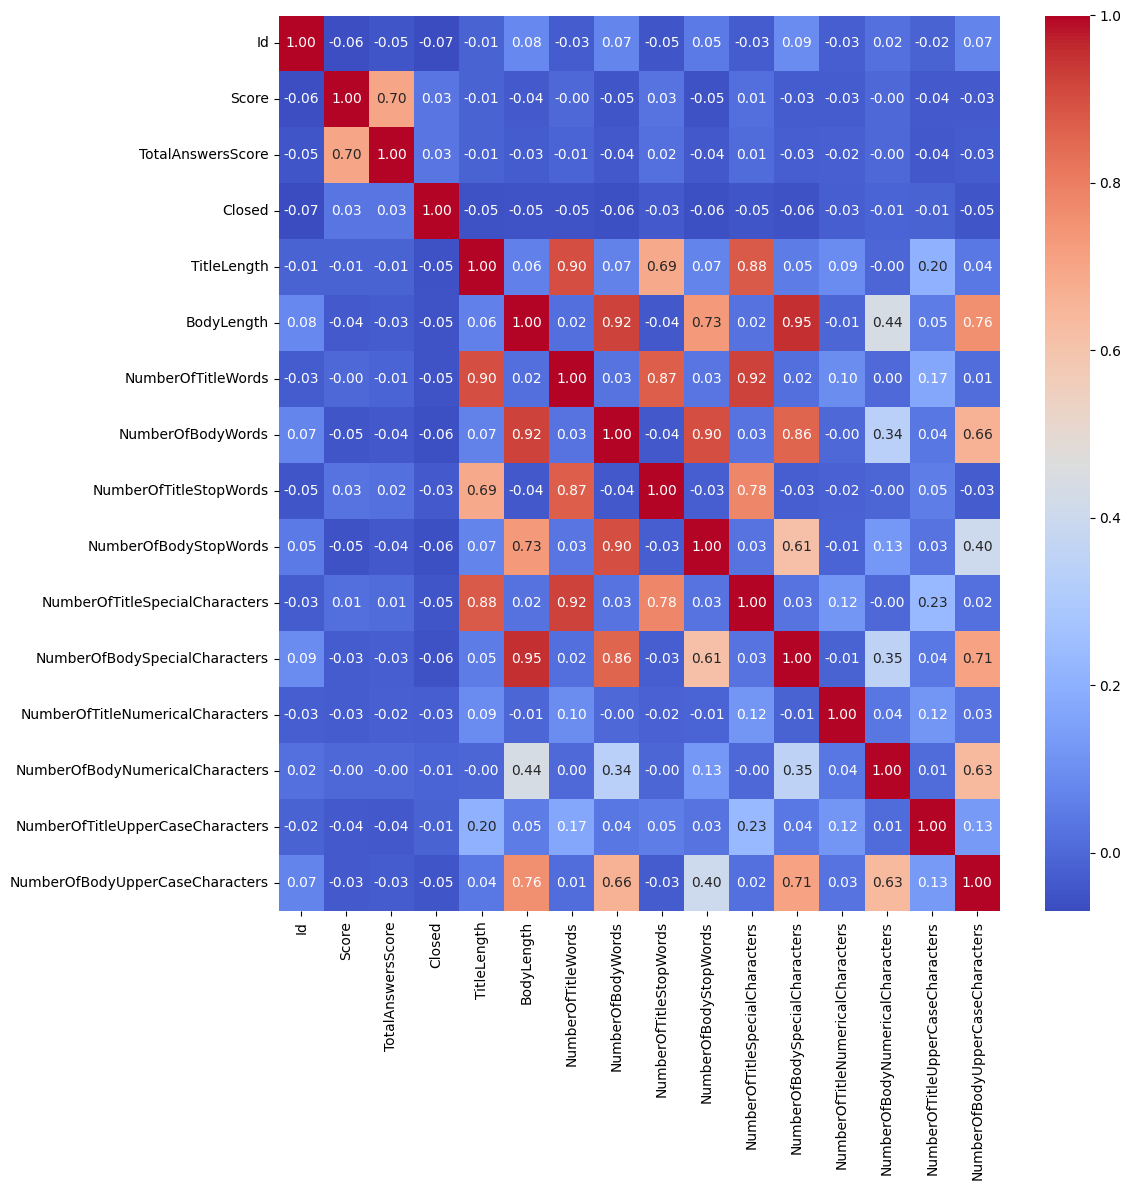

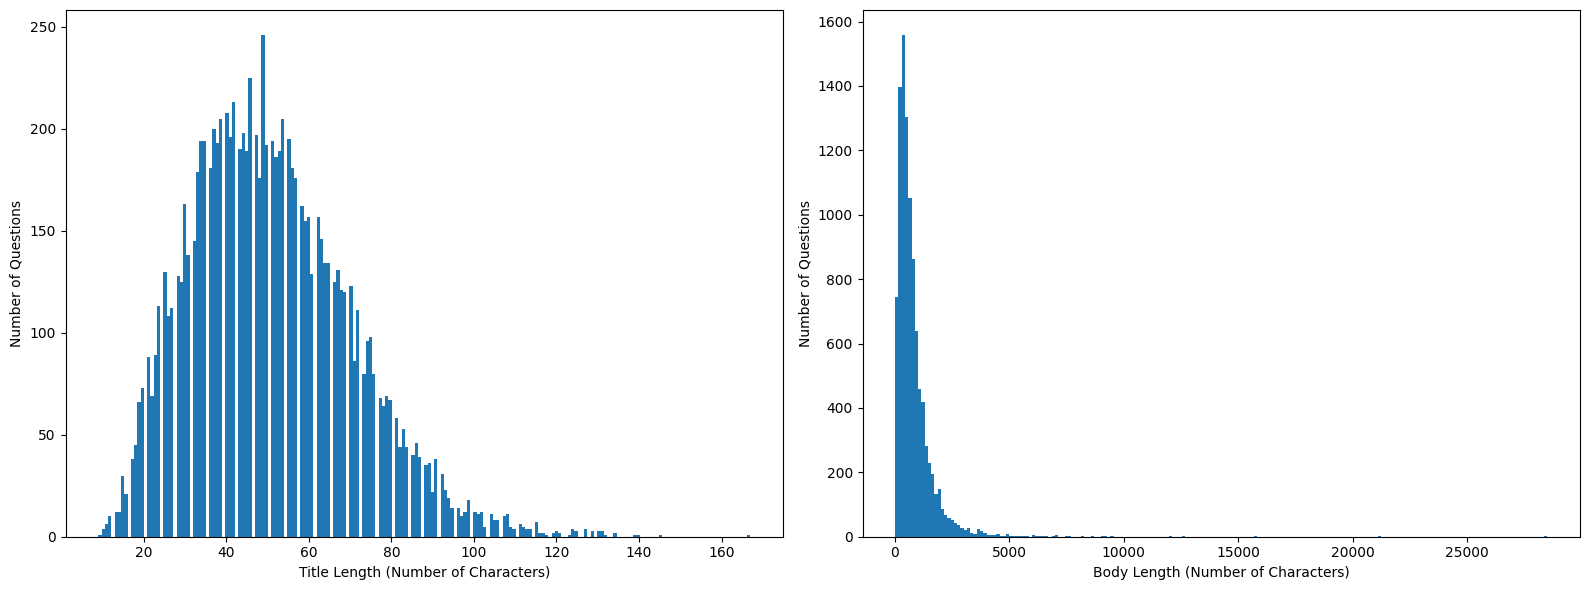

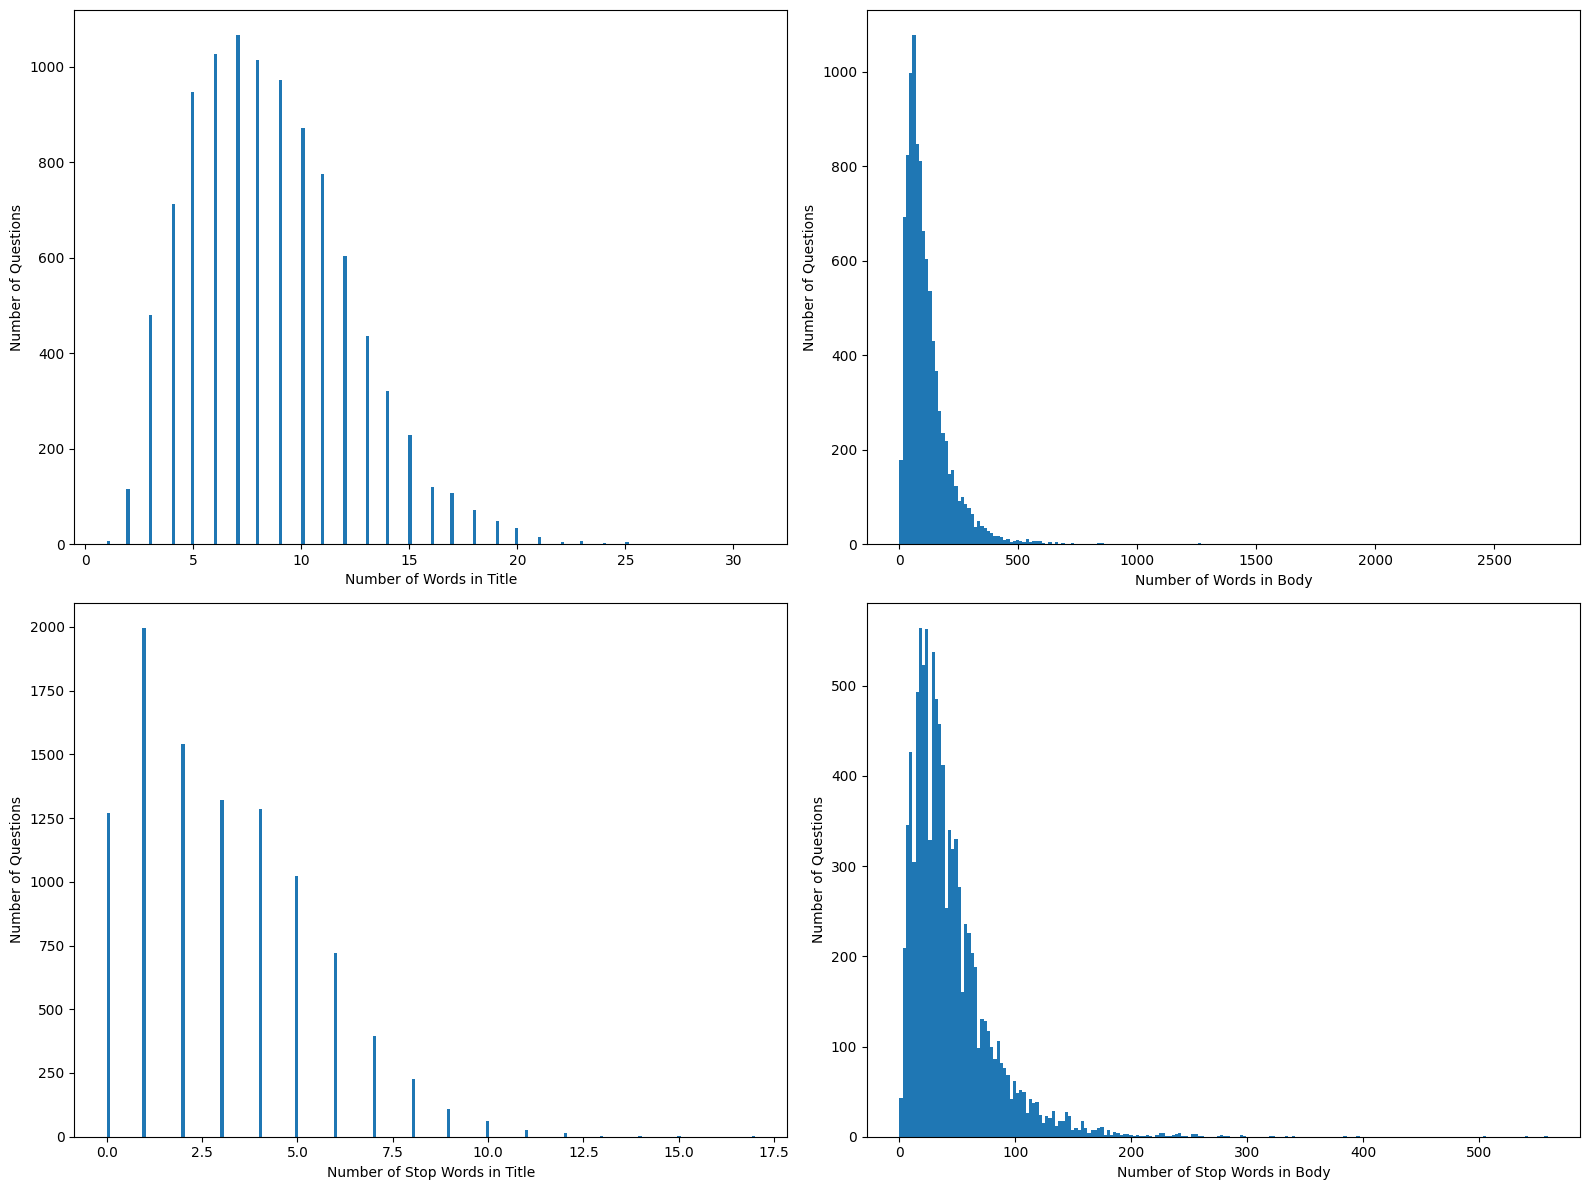

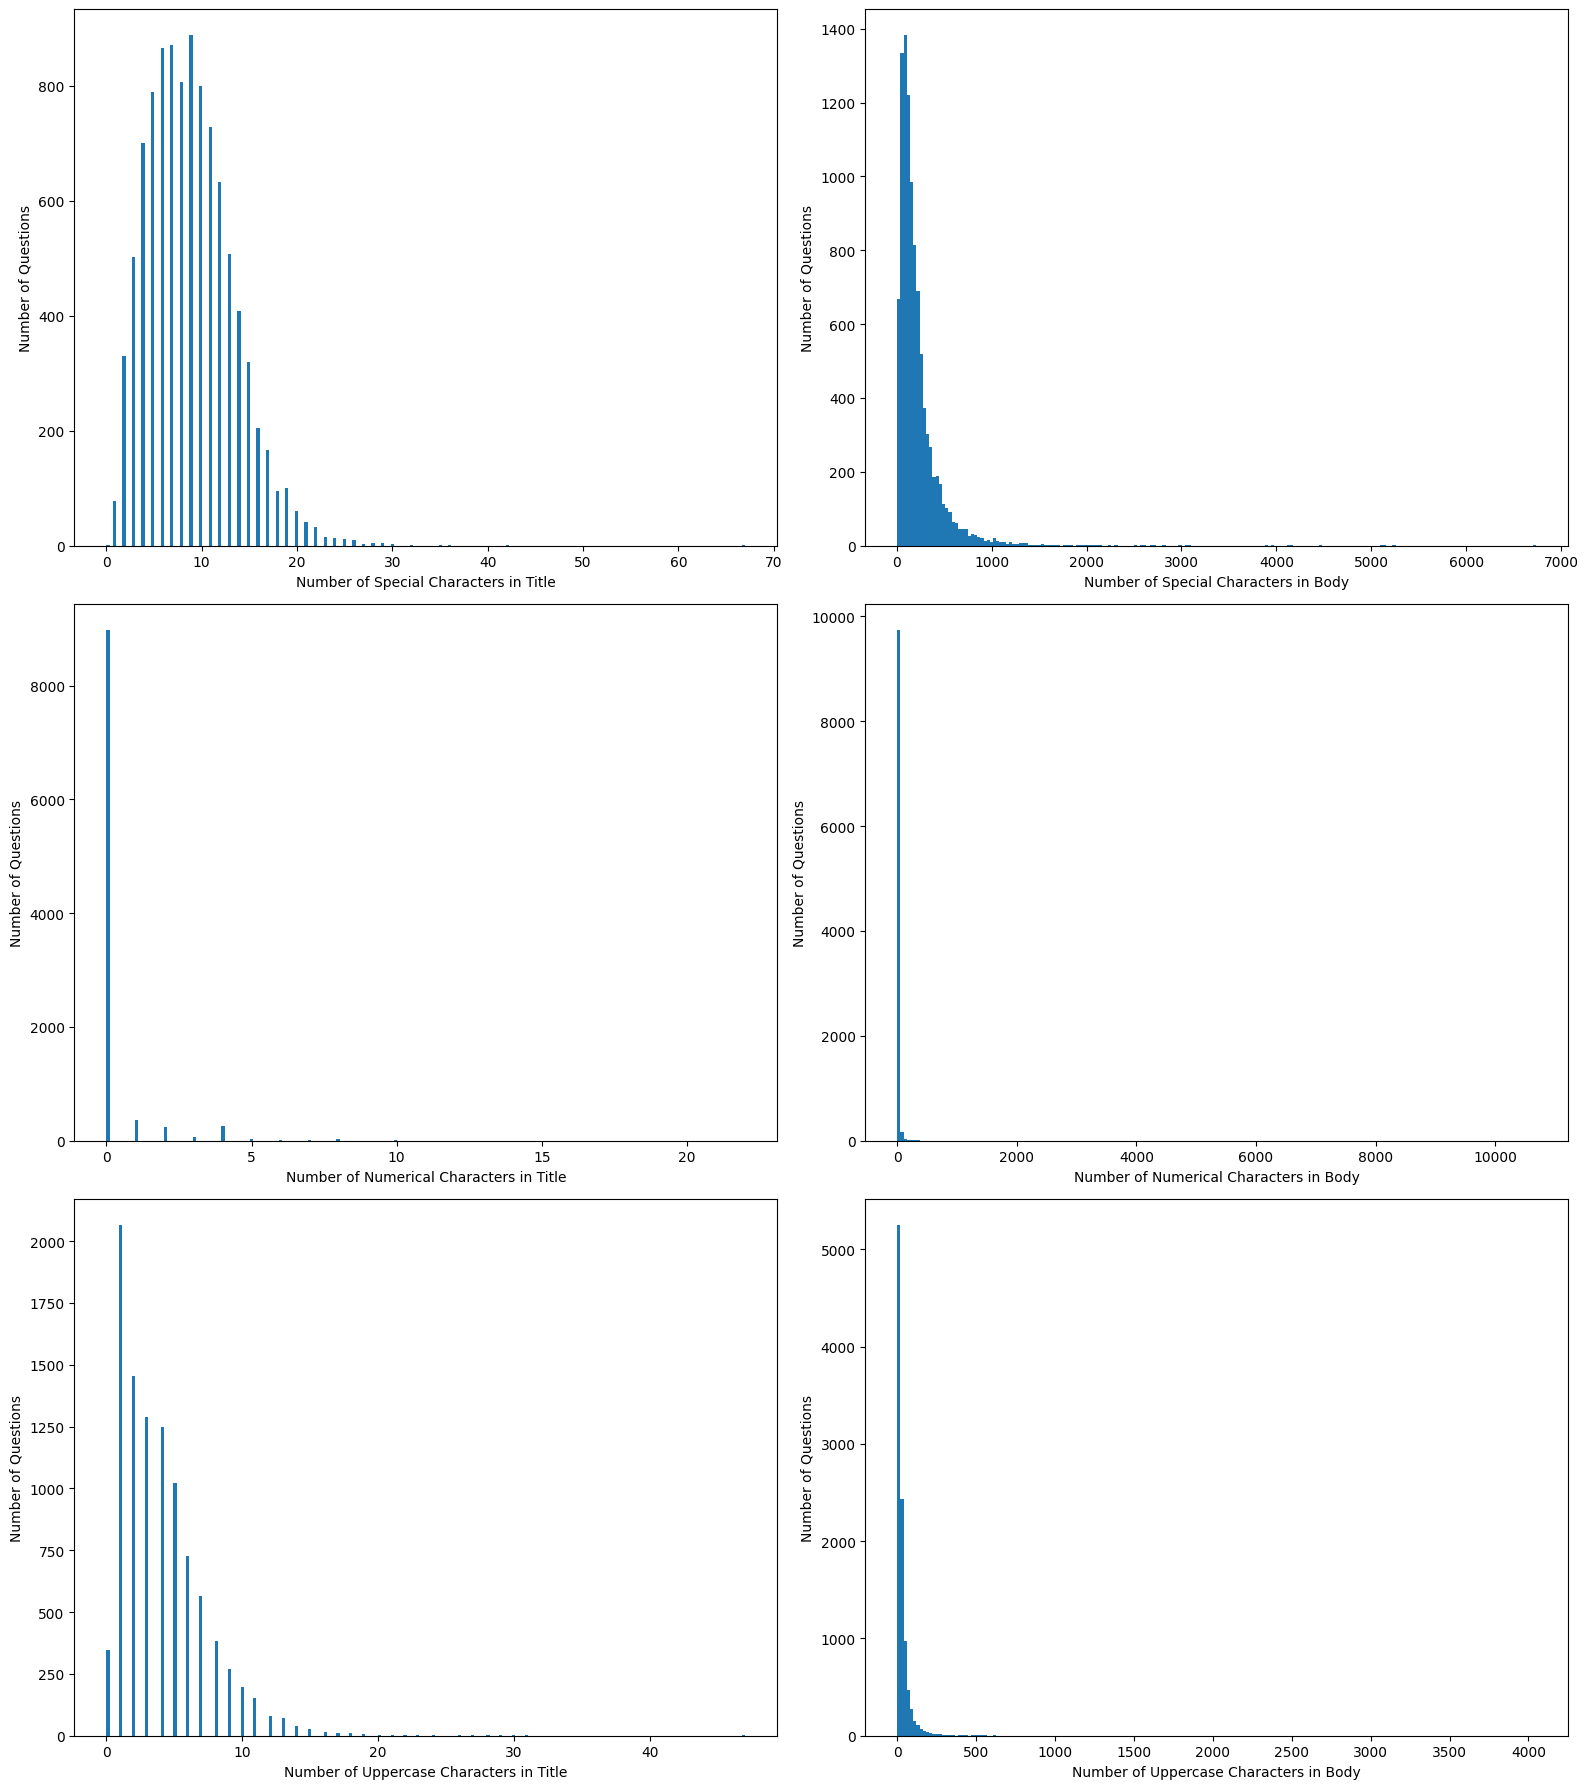

In [54]:
data_analysis_path = './data_analysis/'
processed_file_path = './First_10000_Questions_with_TotalAnswersScore.csv' # WARNING TEST PATH FOR DEBUG MODE
analyzed_file_path = './Analyzed_Questions.csv'

analysis = DataAnalysis(processed_file_path, data_analysis_path)
analysis.calculate_lengths()
analysis.calculate_word_counts()
analysis.calculate_characteristics()
analysis.plot_correlation_matrix()
analysis.calculate_tfidf()
analysis.plot_distributions()
analysis.save_analyzed_data(analyzed_file_path)

del analysis

In [55]:

modified_qustions_df = pd.read_csv(analyzed_file_path, encoding="ISO-8859-1")

In [56]:
modified_qustions_df.head()

,Id,Score,Title,Body,TotalAnswersScore,Closed,TitleLength,BodyLength,NumberOfTitleWords,NumberOfBodyWords,NumberOfTitleStopWords,NumberOfBodyStopWords,NumberOfTitleSpecialCharacters,NumberOfBodySpecialCharacters,NumberOfTitleNumericalCharacters,NumberOfBodyNumericalCharacters,NumberOfTitleUpperCaseCharacters,NumberOfBodyUpperCaseCharacters,TitleTfidf,BodyTfidf
0,80,26,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...,19.0,False,58,1941,7,186,1,28,10,553,0,11,4,147,[0. 0. 0. 0. 0...,[0. 0. 0. 0. 0...
1,90,144,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...,34.0,True,53,249,7,25,2,8,7,62,0,2,5,8,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,[0. 0.30805503 0. 0. 0...
2,120,21,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...,9.0,False,17,431,3,56,0,16,3,104,0,0,8,26,[0. 0. 0. 0. 0...,[0. 0. 0. 0. 0...
3,180,53,Function for creating color wheels,<p>This is something I've pseudo-solved many t...,54.0,False,34,260,5,41,1,18,4,63,0,0,1,6,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,[0. 0. 0. 0. 0...
4,260,49,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...,63.0,False,51,1190,6,176,1,77,6,290,0,7,4,40,[0. 0. 0. 0. 0...,[0. 0.09833547 0. 0. 0...


In [ ]:
from sklearn.model_selection import train_test_split

x = X_combined.drop('Score', axis=1)
y = modified_qustions_df['Score']

X_train, X_temp, y_train, y_temp = train_test_split(x, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)



### Training AI

In [ ]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.ensemble import RandomForestRegressor
import numpy as np

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

regressor = RandomForestRegressor(n_estimators=100, random_state=42)

plot_learning_curve(regressor, "Learning Curve (Random Forest)", x, y, cv=5, n_jobs=4)
plt.show()


# AI Training (New)

### Prepering data for training

In [1]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split

# load processed data
processd_file_path = './Questions_with_TotalAnswersScore.csv'
processed_df = pd.read_csv(processd_file_path, encoding = "ISO-8859-1")

# split data into training and testing sets (95% for training and 5% for testing)
training_df, test_df = train_test_split(processed_df, test_size=0.05, random_state=2137420)
print('Training data size: {}'.format(len(training_df)))
print('Testing data size: {}'.format(len(test_df)))

# create training data directory
training_data_directory = './training_data/'
if not os.path.exists(training_data_directory):
    os.makedirs(training_data_directory)

# save training data to CSV files
training_data_file = os.path.join(training_data_directory, 'training_data.csv')
training_df.to_csv(training_data_file, index=False)

# save testing data to CSV files
test_data_file = os.path.join(training_data_directory, 'test_data.csv')
test_df.to_csv(test_data_file, index=False)

# reset kernel after running this cell to free up memory

In [1]:
# run this cell if you have already downloaded the dataset and processed it and split it into training and testing sets
import os

training_data_directory = './training_data/'
if not os.path.exists(training_data_directory):
    print('Training data directory does not exist')

training_data_file = os.path.join(training_data_directory, 'training_data.csv')
if not os.path.exists(training_data_file):
    print('Training data file does not exist')

test_data_file = os.path.join(training_data_directory, 'test_data.csv')
if not os.path.exists(test_data_file):
    print('Test data file does not exist')

### Data processing

In [2]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('omw-1.4')

stop_words = set(stopwords.words('english'))

def calc_data_statistic(data): 
    # calculating lenght of title and body
    data['TitleLength'] = data['Title'].str.len()
    data['BodyLength'] = data['Body'].str.len()

    # calculating number of words in Title and Body
    data['NumberOfTitleWords'] = data['Title'].apply(lambda x: len(str(x).split(" ")))
    data['NumberOfBodyWords'] = data['Body'].apply(lambda x: len(str(x).split(" ")))

    # calculating the number of stop words in Title and Body
    data['NumberOfTitleStopWords'] = data['Title'].apply(lambda x: len([word for word in x.split() if word.lower() in stop_words]))
    data['NumberOfBodyStopWords'] = data['Body'].apply(lambda x: len([word for word in x.split() if word.lower() in stop_words]))

    # calculating the number special characters in Title and Body
    list_of_special_characters = ['!', '@', '#', '$', '%', '^', '&', '*', '(', ')', '_', '-', '+', '=', '{', '}', '[', ']', '|', '\\', ':', ';', '"', "'", '<', '>', ',', '.', '?', '/', '~', '`']
    data['NumberOfTitleSpecialCharacters'] = data['Title'].apply(lambda x: len([char for char in str(x) if char in list_of_special_characters]))
    data['NumberOfBodySpecialCharacters'] = data['Body'].apply(lambda x: len([char for char in str(x) if char in list_of_special_characters]))

    # calculating the number of numerical characters in Title and Body
    data['NumberOfTitleNumericalCharacters'] = data['Title'].apply(lambda x: len([char for char in str(x) if char.isnumeric()]))
    data['NumberOfBodyNumericalCharacters'] = data['Body'].apply(lambda x: len([char for char in str(x) if char.isnumeric()]))

    # calculating the number of uppercase characters in Title and Body
    data['NumberOfTitleUpperCaseCharacters'] = data['Title'].apply(lambda x: len([char for char in str(x) if char.isupper()]))
    data['NumberOfBodyUpperCaseCharacters'] = data['Body'].apply(lambda x: len([char for char in str(x) if char.isupper()]))

    return data

[nltk_data] Downloading package stopwords to /home/kijada/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/kijada/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [24]:
import re
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
dd
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = set(stopwords.wordsdd('english'))
lemmatizer = WordNetLemmatizer()

max_features_count = 1000
title_features_list = []
body_features_list = []

def normalize_text(text):
    text = text.lower()
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^a-z\s]', '', text)
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words])
    return text

    

[nltk_data] Downloading package stopwords to /home/kijada/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/kijada/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [25]:
def normalize_data_and_convert_to_tfidf_and_save_features_list(data):
    global title_features_list
    global body_features_list

    tfidf_title = TfidfVectorizer(max_features=max_features_count)
    title_tfidf = tfidf_title.fit_transform(data['Title'].astype(str).apply(normalize_text))
    title_tfidf_df = pd.DataFrame(title_tfidf.toarray(), columns=tfidf_title.get_feature_names_out())

    tfidf_body = TfidfVectorizer(max_features=max_features_count)
    body_tfidf = tfidf_body.fit_transform(data['Body'].astype(str).apply(normalize_text))
    body_tfidf_df = pd.DataFrame(body_tfidf.toarray(), columns=tfidf_body.get_feature_names_out())

    title_features_list = title_tfidf_df.columns.tolist()
    body_features_list = body_tfidf_df.columns.tolist()

    combined_data = pd.concat([data.drop(['Title', 'Body', 'Id'], axis=1), title_tfidf_df, body_tfidf_df], axis=1)
    return combined_data

In [26]:
def normalize_data_and_convert_to_tfidf(data):
    global title_features_list
    global body_features_list

    if len(title_features_list) == 0 or len(body_features_list) == 0:
        print('Title and Body features list are empty')
        exit()
    
    tfidf_title = TfidfVectorizer(max_features=max_features_count)
    title_tfidf = tfidf_title.fit_transform(data['Title'].astype(str).apply(normalize_text))
    title_tfidf_df = pd.DataFrame(title_tfidf.toarray(), columns=title_features_list)

    tfidf_body = TfidfVectorizer(max_features=max_features_count)
    body_tfidf = tfidf_body.fit_transform(data['Body'].astype(str).apply(normalize_text))
    body_tfidf_df = pd.DataFrame(body_tfidf.toarray(), columns=body_features_list)

    combined_data = pd.concat([data.drop(['Title', 'Body', 'Id'], axis=1), title_tfidf_df, body_tfidf_df], axis=1)
    return combined_data

In [27]:
def prepare_data_for_training(data_set, test_data = False):
    data_set = calc_data_statistic(data_set)
    
    if test_data == True:
        data_set = normalize_data_and_convert_to_tfidf_and_save_features_list(data_set) # save features list for later use
    else:
        data_set = normalize_data_and_convert_to_tfidf(data_set)

    return data_set

### Main training function

In [5]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def training_iteration(trained_model, x_train, y_train, x_test, y_test):
    # Training function
    trained_model.fit(x_train, y_train)

    # Predicting the test set results
    predictions_result = trained_model.predict(x_test)
    predictions_result = predictions_result.astype(int)
    y_test = y_test.astype(int)
    
    # Calculating the accuracy, precision, recall and f1 score
    accuracy = accuracy_score(y_test, predictions_result)
    precision = precision_score(y_test, predictions_result, average='macro', zero_division=1)
    recall = recall_score(y_test, predictions_result, average='macro', zero_division=1)
    fscore = f1_score(y_test, predictions_result, average='macro', zero_division=1)

    return trained_model, (accuracy, precision, recall, fscore)

### Saving model to file for backup and later use

In [57]:
# Cleaning up models folder
import shutil
model_path = "./models/"
shutil.rmtree(model_path)

In [58]:
import os
import joblib
from datetime import datetime

model_path = "./models/"
if not os.path.exists(model_path):
    os.makedirs(model_path)

def save_model(classifier, id):
    timestam_str = datetime.now().strftime("%Y%m%d_%H%M%S")
    model_name = "model_{}_{}.joblib".format(id, timestam_str)
    model_target_path = os.path.join(model_path, model_name)

    joblib.dump(classifier, model_target_path)

### Function to monitor training time

In [10]:
# function to calculate the time difference to show how long it took to train the model
from datetime import datetime

def get_time_diff(start_time):
    time_delta = (datetime.now() - start_time).total_seconds()
    hours, remainder = divmod(time_delta, 3600)
    minutes, seconds = divmod(remainder, 60)
    time_diff_str = "{:0>2}:{:0>2}:{:05.2f}".format(int(hours), int(minutes), seconds)
    return time_diff_str

### Model preparation

In [11]:
from sklearn.linear_model import SGDClassifier

model = SGDClassifier(random_state=420)

### Load test data

In [28]:
import sys
import pandas as pd

sys.stdout.write("Loading test data... \n")

# Loading test data from CSV file
sys.stdout.write("\tLoading test data from CSV file... \n")
test_df = pd.read_csv(test_data_file, encoding = "ISO-8859-1")

# Preparing test data for training
sys.stdout.write("\tPreparing test data for training... \n")
processed_test_df = prepare_data_for_training(test_df, test_data=True)

# Splitting test data into x and y sets
sys.stdout.write("\tSplitting test data into x and y sets... \n")
x_test_data = processed_test_df.drop('Score', axis=1)
y_test_data = processed_test_df['Score']

sys.stdout.write("\nDone!\n")


Loading test data... 
	Loading test data from CSV file... 
	Preparing test data for training... 
	Splitting test data into x and y sets... 

Done!


7

In [29]:
# print(processed_test_df.head())
# print(x_test_data.head())
# print(y_test_data.head())
processed_test_df.head()


,Score,TotalAnswersScore,Closed,TitleLength,BodyLength,NumberOfTitleWords,NumberOfBodyWords,NumberOfTitleStopWords,NumberOfBodyStopWords,NumberOfTitleSpecialCharacters,...,would,write,writing,written,wrong,wrote,xml,year,yes,yet
0,0,1.0,False,25,2771,6,1017,3,32,1,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0.0,False,96,474,15,76,6,37,2,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,3.0,True,72,585,12,100,3,42,1,...,0.175528,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,0.0,False,32,905,4,154,0,64,0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,0.0,False,48,1444,7,416,1,60,0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Training loop

In [59]:
import sys
import pandas as pd
from datetime import datetime

sys.stdout.write("Training started... \n")
sys.stdout.write("-" * 80 + "\n")

# Configure training parameters
data_batch_is_not_empty = True
bach_size = 5000 # for test 500, for training optimal around 10000 (limit is your RAM)
start_offset = 0 # use if strat

# list to store training results for each batch
training_results_list = []

# save start time
start_time = datetime.now()

# read headers from CSV file
headers_list = pd.read_csv(training_data_file, encoding = "ISO-8859-1", nrows=0, header=0)

# pritnt training parameters to console
sys.stdout.write("training time; start offset; \t accuracy; precision; recall; f1 score\n")

# training loop
while data_batch_is_not_empty:
    # read data batch
    data_batch = pd.read_csv(training_data_file, encoding = "ISO-8859-1", skiprows=start_offset+1, nrows=bach_size, header=None, names=list(headers_list.columns))

    # check if data batch is empty
    if data_batch.empty:
        data_batch_is_not_empty = False
        break

    # while loop emergency break
    if start_offset > 1500000: # 1.5M row, data set have 1.2M rows
        break
    if (datetime.now() - start_time).total_seconds() > (60*60) * 12: # 12 hours
        break

    # while loop break for testing
    if start_offset > 250000: # 250k rows
        break
    
    # prepare data for training
    processed_data_batch = prepare_data_for_training(data_batch)
    x_data_batch = processed_data_batch.drop('Score', axis=1)
    y_data_batch = processed_data_batch['Score']

    # train model
    model, training_result = training_iteration(model, x_data_batch, y_data_batch, x_test_data, y_test_data)
    training_results_list.append(training_result)

    # print training results
    sys.stdout.write("{: <12} \t {: <9} \t\t {:.3f} \t {:.3f} \t {:.3f} \t {:.3f} \n".format(get_time_diff(start_time), start_offset, *training_result))

    # save model
    if start_offset/bach_size % 5 == 0 and start_offset != 0:
        sys.stdout.write("Saving model... \n")
        save_model(model, int(start_offset/bach_size))
    
    # update start offset
    start_offset += bach_size


sys.stdout.write("\nSaving model... \n")
save_model(model, 'final')

sys.stdout.write("-" * 80 + "\n")
sys.stdout.write("Training ended!\n")
sys.stdout.write("Total training time: {}\n".format(get_time_diff(start_time)))
sys.stdout.write("-" * 80 + "\n")



Training started... 
--------------------------------------------------------------------------------
training time; start offset; 	 accuracy; precision; recall; f1 score
00:00:38.65  	 0         		 0.439 	 0.898 	 0.019 	 0.065

Saving model... 
00:01:17.42  	 5000      		 0.089 	 0.912 	 0.018 	 0.044
00:01:55.61  	 10000     		 0.231 	 0.911 	 0.013 	 0.034
00:02:28.76  	 15000     		 0.033 	 0.924 	 0.012 	 0.043
00:03:06.71  	 20000     		 0.339 	 0.932 	 0.020 	 0.040
00:03:43.91  	 25000     		 0.468 	 0.961 	 0.012 	 0.022

Saving model... 
00:04:19.60  	 30000     		 0.098 	 0.945 	 0.012 	 0.037
00:04:55.52  	 35000     		 0.009 	 0.941 	 0.013 	 0.013
00:05:33.62  	 40000     		 0.098 	 0.965 	 0.012 	 0.025
00:06:11.06  	 45000     		 0.077 	 0.929 	 0.021 	 0.046
00:06:52.11  	 50000     		 0.467 	 0.921 	 0.032 	 0.040

Saving model... 
00:07:31.04  	 55000     		 0.431 	 0.880 	 0.034 	 0.075
00:08:10.29  	 60000     		 0.462 	 0.936 	 0.014 	 0.024
00:08:47.12  	 65000 

81

### Show results

In [66]:
import random
random.seed(420)

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn")

for i in range(0, 25):
    index = random.randint(0, len(x_test_data))
    predicted_score = model.predict([x_test_data.iloc[index]])[0]
    print("index: {: <5} \t predicted score: {: <5} \t actual score: {: <5}".format(index, predicted_score, y_test_data.iloc[index]))


index: 1726  	 predicted score: -4    	 actual score: 0    
index: 44113 	 predicted score: 21    	 actual score: 2    
index: 51207 	 predicted score: 0     	 actual score: 0    
index: 23887 	 predicted score: 21    	 actual score: 0    
index: 17865 	 predicted score: 21    	 actual score: 0    
index: 26390 	 predicted score: 21    	 actual score: 0    
index: 6264  	 predicted score: 0     	 actual score: -1   
index: 50065 	 predicted score: 21    	 actual score: 0    
index: 43495 	 predicted score: 21    	 actual score: -1   
index: 44426 	 predicted score: 0     	 actual score: 0    
index: 43016 	 predicted score: 21    	 actual score: 1    
index: 7487  	 predicted score: 0     	 actual score: 0    
index: 1980  	 predicted score: 21    	 actual score: 1    
index: 34201 	 predicted score: 0     	 actual score: 0    
index: 21332 	 predicted score: 21    	 actual score: 0    
index: 31790 	 predicted score: 0     	 actual score: 0    
index: 42619 	 predicted score: 17    	 

### Plot training results

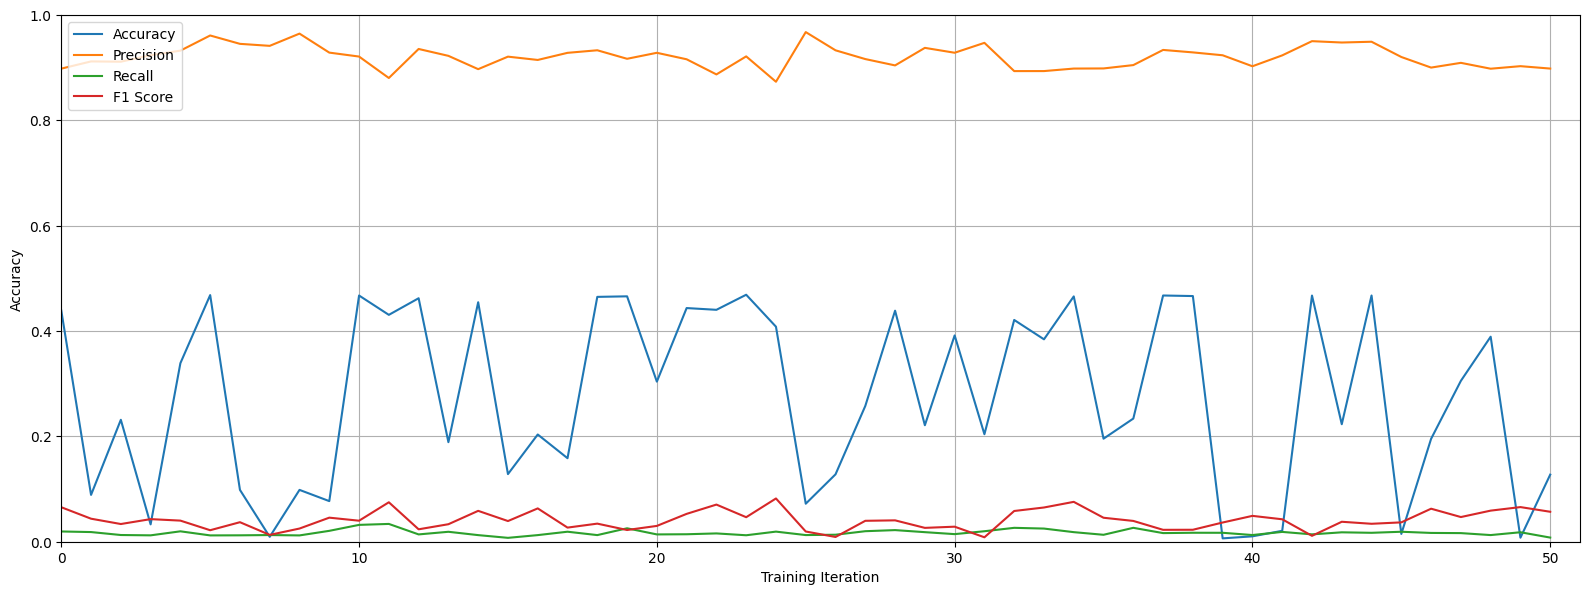

In [60]:
import os
import matplotlib.pyplot as plt

# create data analysis directory
data_analysis_path = './data_analysis/'
if not os.path.exists(data_analysis_path):
    os.makedirs(data_analysis_path)

# converting the performance list to a dataframe
training_result_df = pd.DataFrame(training_results_list, columns=['Accuracy', 'Precision', 'Recall', 'F1 Score'])

# plotting the performance
plt.figure(figsize=(16, 6))

plt.plot(training_result_df['Accuracy'], label='Accuracy')
plt.plot(training_result_df['Precision'], label='Precision')
plt.plot(training_result_df['Recall'], label='Recall')
plt.plot(training_result_df['F1 Score'], label='F1 Score')

plt.xlabel('Training Iteration')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

plt.tight_layout()
plt.grid()

plt.xlim(0, len(training_result_df))
plt.ylim(0, 1)

plt.savefig(data_analysis_path + 'training_iteration_accuracy.png', dpi=300)
plt.show()